# Assignment 3 - Policy Gradient Methods
## Special Topics: Reinforcement Learning KV
### WS 2020

---
<div class="alert alert-warning">

**Due:** 19.01.2021, 13:45
</div>

---

<div class="alert alert-info">
    
In this assignment we will solve the Cartpole balancing problem using the **Policy Gradient Method REINFORCE**.
<br>

In particular we will use a neural network to approximate our policy $\pi(a|s)$. To that end we will rely on an auto-differentiation framwork which will provide us with the gradients of our policy with respect to its parameters.
We will leave it up to you which framework you choose (PyTorch, JAX, Tensorflow, ...), but we won't be able to provide "support" for all of them, of course.

- Our recommendation, which we also used in our tutorials for this class, is **PyTorch**.
- Also **do not use high-level packages** such as "Keras" for solving the assignment. We want to see a clean and "exposed" implementation of REINFORCE.
<br>

To accomplish this exercise read the notebook carefully from beginning to end end fill out to coding parts marked with **TODO**.<br>
Please also **provided comments in your code** to make it is easier for us to understand all the different submissions.
</div>

---

## Python Imports

- Please make sure that you have installed OpenAI gym (https://gym.openai.com/docs/). This should be anyways ready from your previous assignment.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# pytorch imports
# (if you don't want to use PyTorch just replace this with whatever you need)
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
from torch.nn.init import _calculate_fan_in_and_fan_out, calculate_gain



## 1. Implement REINFORCE
In this part of the assignment we will first define the neural network approximating our policy.<br>
In the second part we implement the **REINFORCE** algorithm shown in our class.

## 1.1 Define Policy Network (2 Points)
Define the policy network. The output of this network is the action selection probability for each of the actions (this will require a *softmax* nonlinearity).
You can look in the **07_function_approximation.ipynb** to re-check how you can define a Neural Network in PyTorch.

<div class="alert alert-info">

**Hint:** We solved the task using a neural network with two hidden layers (each 32 units) and SELU nonlinearities. But the architecture design is up to you.
We actually encourage you to play around with it and investigate its impact on the overall performance of the system.
</div>

<div class="alert alert-info">

**Hint:** Make sure to initialize the weights of your neural network properly.
Possible options for initializing your (linear, dense) layers can be found [here](https://pytorch.org/docs/stable/nn.html#torch-nn-init).

We recommend to initialize the weights with a distribution that is appropriate for the nonlinearities used. Have a look at **07_technical_details.ipynb** for examples. However, we again encourage you to play around with this.

</div>

In [3]:
# TODO
class Policy_network(nn.Module):# the one that I found used by some tutorials in RL for this task
    def __init__(self, env, hidden):
        super(Policy_network, self).__init__()

        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 64), 
            nn.SELU(), 
            nn.Linear(64, hidden),
            nn.SELU(), 
            nn.Linear(hidden, hidden),
            nn.SELU(), 
            nn.Linear(hidden,self.n_outputs),
            nn.Softmax(dim=-1))
    
    def forward(self, state):
        action_probs = self.network(torch.FloatTensor(np.array(state)))
        return action_probs
    
class Value_estimator(nn.Module): # Another version
    def __init__(self, env):
        super(Value_estimator, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 64), 
            nn.SELU(), 
            nn.Linear(64, 32),
            nn.SELU(), 
            nn.Linear(32,1))
    def forward(self, state):
        action_probs = self.network(torch.FloatTensor(np.array(state)))
        return action_probs

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


## 1.2 Reinforce (8 Points)
Implement an agent which learns by the REINFORCE algorithm ... <br>

<div class="alert alert-info"> 

**Hints:**
- We used the Adam update rule with a learning rate of $10^{-4}$ for Stochastic Gradient Ascent.<br>
- We used a discounting factor $\gamma = 0.9$ for computing the returns $G_t$
</div>

In [4]:

class Reinforce(object): # inspired by https://github.com/bentrevett/pytorch-rl/blob/master/1%20-%20Vanilla%20Policy%20Gradient%20(REINFORCE)%20%5BCartPole%5D.ipynb
    """
    REINFORCE Agent
    """
    def __init__(self, env, alpha, use_baseline=False):
        """
        Constructor
        
        @env: OpenAI gym environment the agent should interact with
        @alpha (float): learning rate of policy optimizer
        @use_baseline (bool): whether to use a baseline or not
        """
        # TODO
        self.alpha = alpha
        self.env = env
        self.baseline = use_baseline
        self.reset()
    def reset(self):
        """
        Reset agent:
            - instantiate new policy network
            - initialize the parameters of the network
            - instantiate new policy optimizer (e.g. optim.Adam)
        """
        # TODO
        self.action_space = np.arange(env.action_space.n)
        self.model = Policy_network(self.env,32)
        self.optimizer = optim.Adam(self.model.parameters(),lr=self.alpha)
        self.model.apply(weights_init)
        if self.baseline:
            self.value_es = Value_estimator(self.env)
            self.optimizer_val = optim.Adam(self.value_es.parameters(),lr=self.alpha)
            self.value_es.apply(weights_init)
            

    def choose_action(self, state):
        """
        Select action given a certain state:
            - compute output of policy network (softmax)
            - sample from network output
            - compute action index
        
        Returns:
            @action (integer): index of selected action
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.model(state)
        self.dist = distributions.Categorical(action_probs)
        action = self.dist.sample()
        action_log_prob = self.dist.log_prob(action)
        action = action.item()
        return action,action_log_prob
    def update(self, states, actions, log_probs, rewards, gamma):
        """
        Update parameters of agent
        (in particular the parameters of the policy network)
        
        Inputs (have to match the function "generate_episode"):
            @states (float array): trajectory of observed states
            @actions (int array): vector of selected actions
            @rewards (float array): trajectory of received rewards
            @gamma (float): discounting rate
        """
        # TODO

        states_tensor = torch.tensor(states, device = device, dtype=torch.float)
        reward_tensor = torch.tensor(rewards, device = device, dtype=torch.float)
        action_tensor = torch.tensor(actions, device = device, dtype=torch.long)
        if self.baseline:
            for idx in range(len(states)-1):
                G = reward_tensor[idx:].sum()
                value_prediction = self.value_es(states_tensor[idx])
                delta = G - value_prediction
                
                value_loss = -delta * value_prediction
                policy_loss = -delta * torch.log(self.model(states_tensor[idx])[action_tensor[idx]])
                
                self.optimizer_val.zero_grad()
                self.optimizer.zero_grad()
                value_loss.backward(retain_graph=True)
                policy_loss.backward(retain_graph=True)
                self.optimizer.step()
                self.optimizer_val.step()
        else:
            for idx in range(len(states)-1):
                G = 0
                for k in range(idx+1, len(states)):
                    G = G + gamma**(k-idx-1) * reward_tensor[k]
                    
                policy_loss = -gamma**idx * G * torch.log(self.model(states_tensor[idx])[action_tensor[idx]])
                
                self.optimizer.zero_grad()
                policy_loss.backward(retain_graph=True)
                self.optimizer.step()


In [5]:

class Reinforce(object): # inspired by https://github.com/bentrevett/pytorch-rl/blob/master/1%20-%20Vanilla%20Policy%20Gradient%20(REINFORCE)%20%5BCartPole%5D.ipynb
    """
    REINFORCE Agent
    """
    def __init__(self, env, alpha, use_baseline=False):
        """
        Constructor
        
        @env: OpenAI gym environment the agent should interact with
        @alpha (float): learning rate of policy optimizer
        @use_baseline (bool): whether to use a baseline or not
        """
        # TODO
        self.alpha = alpha
        self.env = env
        self.baseline = use_baseline
        self.reset()
    def reset(self):
        """
        Reset agent:
            - instantiate new policy network
            - initialize the parameters of the network
            - instantiate new policy optimizer (e.g. optim.Adam)
        """
        # TODO
        self.action_space = np.arange(env.action_space.n)
        self.model = Policy_network(self.env,32)
        self.model.apply(weights_init)
        self.optimizer = optim.Adam(self.model.network.parameters(),lr=self.alpha)
        if self.baseline:
            self.value_es = Value_estimator(self.env)
            self.optimizer_val = optim.Adam(self.value_es.network.parameters(),lr=1e-5)
            

    def choose_action(self, state):
        """
        Select action given a certain state:
            - compute output of policy network (softmax)
            - sample from network output
            - compute action index
        
        Returns:
            @action (integer): index of selected action
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.model(state)
        self.dist = distributions.Categorical(action_probs)
        action = self.dist.sample()
        action_log_prob = self.dist.log_prob(action)
        action = action.item()
        return action,action_log_prob
    def update(self, states, actions, log_probs, rewards, gamma):
        """
        Update parameters of agent
        (in particular the parameters of the policy network)
        
        Inputs (have to match the function "generate_episode"):
            @states (float array): trajectory of observed states
            @actions (int array): vector of selected actions
            @rewards (float array): trajectory of received rewards
            @gamma (float): discounting rate
        """
        # TODO

        states_tensor = torch.tensor(states, dtype=torch.float)
        reward_tensor = torch.tensor(rewards, dtype=torch.float)
        action_tensor = torch.tensor(actions, dtype=torch.long)
        
        if self.baseline:
            for idx in range(len(states)-1):
                G = reward_tensor[idx:].sum()
                value_prediction = self.value_es(states_tensor[idx])
                delta = G - value_prediction
                
                value_loss = -delta * value_prediction
                policy_loss = -delta * torch.log(self.model(states_tensor[idx])[action_tensor[idx]])
                
                self.optimizer_val.zero_grad()
                self.optimizer.zero_grad()
                value_loss.backward(retain_graph=True)
                policy_loss.backward(retain_graph=True)
                self.optimizer.step()
                self.optimizer_val.step()
        else:
            for idx in range(len(states)-1):
                G = 0
                for k in range(idx+1, len(states)):
                    G = G + gamma**(k-idx-1) * reward_tensor[k]
                    
                policy_loss = -gamma**idx * G * torch.log(self.model(states_tensor[idx])[action_tensor[idx]])
                
                self.optimizer.zero_grad()
                policy_loss.backward(retain_graph=True)
                self.optimizer.step()

# 2. Generate one Episode (4 Points)
This function should generate a full episode following the agent's paremetrized policy $\pi_{\theta}(a | s)$.

In [6]:
def generate_episode(env, agent, max_steps, render=False):
    """
    Generates one episode (S0, A0, R1, ..., RT) on a given
    environment following the agent's policy.
    
    Inputs:
        @env (OpenAI Gym environment): the environment to interact with
        @agent (as defined above): the agent (policy) to follow
        @max_steps (integer): maximum number of steps in episode
        @render (boolean): render environment after each action
    
    Returns:
        @states (float array): trajectory of observed states
        @actions (int array): vector of selected actions
        @rewards (float array): trajectory of received rewards
        @total_reward (numerical): total accumulated reward of episode (this is **not** the return!)
    """
    # TODO
    step = 0
    state = env.reset()
    rewards = []
    actions = []
    states = []
    log_action_probs = []
    done = False
    total_reward = 0
    while done==False and step<max_steps:
        action,log_action_prob = agent.choose_action(state)
        state_1,reward,done,_ = env.step(action)
        step+=1
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        log_action_probs.append(log_action_prob)
        state=state_1
        if done:
            total_reward = sum(rewards)
            break
        if step==max_steps:
          break
        
    return states, actions, rewards, log_action_probs, total_reward

# 3. Run Experiment (3 Points)
This function runs one experiment and returns an array containing the reward achieved within each episode.

In [7]:
def run_experiment(env, agent, gamma, max_episodes=300, max_steps=200):
    """
    Runs one experiment with given agent on the given environment for a certain number of episodes.
    
    Inputs:
        @env (OpenAI Gym environment): the environment to interact with
        @agent (as defined above): the agent (policy) to follow
        @max_episodes (integer): maximum number of episodes to train on.
        @max_steps (integer): maximum number of steps in episode.
    
    Returns:
        @total_rewards (vector with length <max_episodes>): containing the total rewards per episode
    """
    # TODO
    ep=0
    total_rewards = []
    while ep<max_episodes:
        states, actions, rewards, log_action_probs, total_reward = generate_episode(env,agent,max_steps)
        total_rewards.append(total_reward)
        #print(total_reward)
        agent.update(states,actions,log_action_probs,rewards,gamma)
        ep+=1
    return total_rewards

# 4. Train
This is the part where we actually train our agent. Make sure that your code allows to re-run the same experiment a couple of times. We will need this in the next part of the assignment.

In [8]:
# we'll use a "mother" random number generator to choose the seeds for the different
# random number generators used in the experiments below
# this is so we have **reproducible** results!


# please note, that on GPUs, this is not as easy!
# GPUs have non-deterministic operations, for which
# deterministic equivalents might not exist!

# the networks in question will be tiny, so you do **not need a GPU**!

seed_generator = np.random.default_rng(4711)

gamma = 0.99
max_steps = 200         # maximum time steps per episode
max_episodes = 500      # overall maximum number of episodes
num_experiments = 5     # number of experimental re-runs

# init book keeping of rewards
rewards = np.zeros((num_experiments, max_episodes))

# run multiple experiments to get reliable performance estimates
for exp in range(num_experiments):
    # we draw a seed for each randomness source in an experiment
    # you might need to adapt this to the framework you are actually using
    numpy_seed = seed_generator.integers(0, 2 ** 32 - 1)
    torch_seed = seed_generator.integers(0, 2 ** 32 - 1)
    env_seed = int(seed_generator.integers(0, 2 ** 32 - 1))
    print('experiment', exp + 1)
    print('numpy seed', numpy_seed)
    print('torch seed', torch_seed)
    print('env seed  ', env_seed)

    ####################################################################
    # provide exact same starting conditions for "Reinforce" agent
    env = gym.make('CartPole-v0')
    np.random.seed(numpy_seed)
    torch.manual_seed(torch_seed)
    env.seed(env_seed)

    # REINFORCE agent
    agent = Reinforce(env, alpha=1e-4)
    rewards[exp, ] = run_experiment(env, agent, gamma, max_episodes, max_steps)

experiment 1
numpy seed 1836726047
torch seed 903154475
env seed   571742415
experiment 2
numpy seed 817575766
torch seed 287759766
env seed   789449501
experiment 3
numpy seed 35943333
torch seed 2760260225
env seed   3198490648
experiment 4
numpy seed 2539010496
torch seed 4045701455
env seed   3607925738
experiment 5
numpy seed 234401814
torch seed 3044374479
env seed   3967184447


# 5. Visualize the performance of your agent (3 Points)
In order to visualize the performance of your agent **re-train it for 5 times** and keep the reward per episode for each of these runs.
<br>
To be clear:
Run each of the five experiment for a maximum of 200 episodes. What you should end up with is a reward-matrix with shape (5 x 200).
<br><br>
Visualize this reward-matrix via the provided **tsplot** showing the mean and standard deviation of your collected rewards.
<br>

<div class="alert alert-info">

**Remarks:**

- set the limits of your y-axis to [0, 220] to produce comparable plots (or even better, compare everything in one figure).
- use legends and appropriate titles in your figures
- put labels onto the x and y axis

</div>

In [27]:
def tsplot(data, label=None, title=None, **kw):

    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x, cis[0], cis[1], alpha=0.2, **kw)
    plt.plot(x, est, label=label, **kw)
    plt.title(title)
    plt.ylim(0,220)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.margins(x=0)

In [10]:
# we'll use a "mother" random number generator to choose the seeds for the different
# random number generators used in the experiments below
# this is so we have **reproducible** results!


# please note, that on GPUs, this is not as easy!
# GPUs have non-deterministic operations, for which
# deterministic equivalents might not exist!

# the networks in question will be tiny, so you do **not need a GPU**!

seed_generator = np.random.default_rng(4711)

gamma = 0.99
max_steps = 200         # maximum time steps per episode
max_episodes = 200      # overall maximum number of episodes
num_experiments = 5     # number of experimental re-runs

# init book keeping of rewards
rewards = np.zeros((num_experiments, max_episodes))

# run multiple experiments to get reliable performance estimates
for exp in range(num_experiments):
    # we draw a seed for each randomness source in an experiment
    # you might need to adapt this to the framework you are actually using
    numpy_seed = seed_generator.integers(0, 2 ** 32 - 1)
    torch_seed = seed_generator.integers(0, 2 ** 32 - 1)
    env_seed = int(seed_generator.integers(0, 2 ** 32 - 1))
    print('experiment', exp + 1)
    print('numpy seed', numpy_seed)
    print('torch seed', torch_seed)
    print('env seed  ', env_seed)

    ####################################################################
    # provide exact same starting conditions for "Reinforce" agent
    env = gym.make('CartPole-v0')
    np.random.seed(numpy_seed)
    torch.manual_seed(torch_seed)
    env.seed(env_seed)

    # REINFORCE agent
    agent = Reinforce(env, alpha=1e-4)
    rewards[exp, ] = run_experiment(env, agent, gamma, max_episodes, max_steps)

experiment 1
numpy seed 1836726047
torch seed 903154475
env seed   571742415
experiment 2
numpy seed 817575766
torch seed 287759766
env seed   789449501
experiment 3
numpy seed 35943333
torch seed 2760260225
env seed   3198490648
experiment 4
numpy seed 2539010496
torch seed 4045701455
env seed   3607925738
experiment 5
numpy seed 234401814
torch seed 3044374479
env seed   3967184447


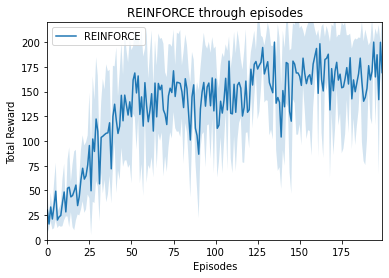

In [28]:
tsplot(rewards,label ='REINFORCE', title = 'REINFORCE through episodes')

# 6. REINFORCE with Baseline (5 Points)
Implement **REINFORCE with Baseline**.

- You can either create a new class or include the implementation into *REINFORCE* above. ( instead of re-running the code again I just run it above)
- Run your implementation and compare *REINFORCE* and *REINFORCE with Baseline* in the experiments above.

**Hints**:
- Don't forget to discount your rewards when trying to learn a value function (see lecture slides)
- If it does not work out of the box, don't get frustrated. It is not that easy to get the balance between the two different learning rates for the policy- and the value-network right. Grid search / Random search is your friend
- Don't share the network parameters for policy and value network for this example. Use individual networks for each of them
- Make sure the **output** of your **value network** is **linear** (e.g.: don't use a nonlinearity in the last layer)
- If learning is unstable you can try to use smaller learning rates
- Take a look at the **gradient magnitudes** and the **update magnitudes** of your network (see **07_technical_details.ipynb** on how you might do that)

In [29]:
# we'll use a "mother" random number generator to choose the seeds for the different
# random number generators used in the experiments below
# this is so we have **reproducible** results!


# please note, that on GPUs, this is not as easy!
# GPUs have non-deterministic operations, for which
# deterministic equivalents might not exist!

# the networks in question will be tiny, so you do **not need a GPU**!

seed_generator = np.random.default_rng(4711)

gamma = 0.99
max_steps = 200         # maximum time steps per episode
max_episodes = 200      # overall maximum number of episodes
num_experiments = 5     # number of experimental re-runs

# init book keeping of rewards
rewards = np.zeros((num_experiments, max_episodes))
rewards_bl = np.zeros((num_experiments,max_episodes))

# run multiple experiments to get reliable performance estimates
for exp in range(num_experiments):
    # we draw a seed for each randomness source in an experiment
    # you might need to adapt this to the framework you are actually using
    numpy_seed = seed_generator.integers(0, 2 ** 32 - 1)
    torch_seed = seed_generator.integers(0, 2 ** 32 - 1)
    env_seed = int(seed_generator.integers(0, 2 ** 32 - 1))
    print('experiment', exp + 1)
    print('numpy seed', numpy_seed)
    print('torch seed', torch_seed)
    print('env seed  ', env_seed)

    ####################################################################
    # provide exact same starting conditions for "Reinforce" agent
    env = gym.make('CartPole-v0')
    np.random.seed(numpy_seed)
    torch.manual_seed(torch_seed)
    env.seed(env_seed)

    # REINFORCE agent
    agent = Reinforce(env, alpha=1e-4)
    rewards[exp, ] = run_experiment(env, agent, gamma, max_episodes, max_steps)
    
    ####################################################################
    # provide exact same starting conditions for "Reinforce with baseline" agent
    env = gym.make('CartPole-v0')
    np.random.seed(numpy_seed)
    torch.manual_seed(torch_seed)
    env.seed(env_seed)
    #print('___________________baseline___________________________')
    # REINFORCE with Baseline Agent
    agent_bl = Reinforce(env, alpha= 1e-4, use_baseline=True)
    rewards_bl[exp, ] = run_experiment(env, agent_bl, gamma, max_episodes, max_steps)

experiment 1
numpy seed 1836726047
torch seed 903154475
env seed   571742415
experiment 2
numpy seed 817575766
torch seed 287759766
env seed   789449501
experiment 3
numpy seed 35943333
torch seed 2760260225
env seed   3198490648
experiment 4
numpy seed 2539010496
torch seed 4045701455
env seed   3607925738
experiment 5
numpy seed 234401814
torch seed 3044374479
env seed   3967184447


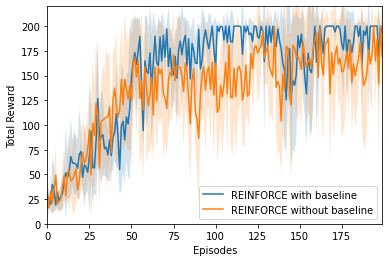

In [30]:
tsplot(rewards_bl,label ='REINFORCE with baseline',title='REINFORCE with vs without baseline')
tsplot(rewards,label = 'REINFORCE without baseline')


# 7. Visual Inspection (0 Points, $\infty$ fun)

<div class="alert alert-info">

Once you are done with training your agents you can visually inspect their behavior of your agent by calling the function *env.render()* after each step.
</div>

In [14]:
import time
env = gym.make('CartPole-v0')

for i_episode in range(5):
    observation = env.reset()
    for t in range(200):
        env.render()
        time.sleep(0.02)
        
        # TODO: replace this with your trained agent for action selection.
        action = agent.choose_action(observation)
        
        observation, reward, done, info = env.step(action)
        
        if done:
            break

NoSuchDisplayException: ignored